In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import yfinance as yf
from datetime import datetime
# import autosklearn.classification
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, f1_score
import mlflow
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBClassifier
import optuna


RANDOM_SEED = 33

/home/julio/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Importando dados

In [2]:
PATH_PETR4_TABULAR_TRAIN = 'FinalDatasets/PETR4/PETR4_tabular_train.csv'
PATH_PETR4_TABULAR_TEST = 'FinalDatasets/PETR4/PETR4_tabular_test.csv'

# PETR4
df_petr4_train = pd.read_csv(PATH_PETR4_TABULAR_TRAIN)
df_petr4_test = pd.read_csv(PATH_PETR4_TABULAR_TEST)

X_petr4_train = df_petr4_train.drop(['hasRise', 'Date'], axis='columns')
y_petr4_train = df_petr4_train['hasRise']

X_petr4_test = df_petr4_test.drop(['hasRise', 'Date'], axis='columns')
y_petr4_test = df_petr4_test['hasRise']

In [3]:
PATH_VALE3_TABULAR_TRAIN = 'FinalDatasets/VALE3/VALE3_tabular_train.csv'
PATH_VALE3_TABULAR_TEST = 'FinalDatasets/VALE3/VALE3_tabular_test.csv'

# vale3
df_vale3_train = pd.read_csv(PATH_VALE3_TABULAR_TRAIN)
df_vale3_test = pd.read_csv(PATH_VALE3_TABULAR_TEST)

X_vale3_train = df_vale3_train.drop(['hasRise', 'Date'], axis='columns')
y_vale3_train = df_vale3_train['hasRise']

X_vale3_test = df_vale3_test.drop(['hasRise', 'Date'], axis='columns')
y_vale3_test = df_vale3_test['hasRise']

# Modelagem: XGBoost

**Preparando função para registrar experimentos com MLFlow**

In [4]:
def mlflow_callback(study, trial):
    with mlflow.start_run(nested=True):
        mlflow.log_params(trial.params)
        mlflow.log_metric("accuracy", trial.value)

In [5]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    # Plotar a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

    # Nomear os eixos
    plt.xlabel('Predito', fontsize=14)
    plt.ylabel('Verdadeiro', fontsize=14)

    # Adicionar rótulos dos eixos X e Y
    plt.xticks([0.5, 1.5], ['Classe 0', 'Classe 1'])
    plt.yticks([0.5, 1.5], ['Classe 0', 'Classe 1'])

    # Adicionar título
    plt.title('Matriz de Confusão', fontsize=16)

    # Exibir o gráfico
    plt.show()

In [6]:
def print_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    # Plotar a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

    # Nomear os eixos
    plt.xlabel('Predito', fontsize=14)
    plt.ylabel('Verdadeiro', fontsize=14)

    # Adicionar rótulos dos eixos X e Y
    plt.xticks([0.5, 1.5], ['Classe 0', 'Classe 1'])
    plt.yticks([0.5, 1.5], ['Classe 0', 'Classe 1'])

    # Adicionar título
    plt.title('Matriz de Confusão', fontsize=16)

    # Exibir o gráfico
    plt.show()

## VALE3

Observando a quantidade de eventos no conjunto de treino/validação e teste. Podemos concluir que os modelos, por serem treinados com um dataset levemente desbalanceado, possuem maior viés para indicar a predição positiva `hasRise=1`, devido que, em geral, 

In [7]:
y_vale3_train.value_counts(normalize=True)

hasRise
0    0.503979
1    0.496021
Name: proportion, dtype: float64

In [8]:
y_vale3_test.value_counts(normalize=True)

hasRise
0    0.581967
1    0.418033
Name: proportion, dtype: float64

In [13]:
def objective_xgboost(trial):
    # Definir o espaço de busca dos hiperparâmetros
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'tree_method': 'auto',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'eta': trial.suggest_float('eta', 1e-4, 1e-1, log=True), # Learning rate
        'max_depth': trial.suggest_int('max_depth', 3, 10), # Profundida maxima das arvores
        'lambda': trial.suggest_float('lambda', 1e-4, 1.0, log=True), # Termo de regularização
    }
    
    # Configurando o KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    
    # Inicializando o modelo XGBoost
    model = XGBClassifier(**param)
    
    # Realizando a validação cruzada
    scores = cross_val_score(model, X_vale3_train, y_vale3_train, cv=kf, scoring='accuracy')
    
    # Retornando a média dos scores como objetivo a ser minimizado
    return np.mean(scores)

/home/julio/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
mlflow.set_experiment("XGBoost VALE3")
study = optuna.create_study(direction='maximize')
study.optimize(objective_xgboost, n_trials=300, callbacks=[mlflow_callback])

[I 2024-07-11 02:59:20,008] A new study created in memory with name: no-name-43a630da-d8e5-43a4-8094-fadc7ebedb09
[I 2024-07-11 02:59:20,672] Trial 0 finished with value: 0.5276491228070176 and parameters: {'eta': 0.0006063376976482321, 'max_depth': 5, 'lambda': 0.009565695426950604}. Best is trial 0 with value: 0.5276491228070176.
[I 2024-07-11 02:59:21,259] Trial 1 finished with value: 0.509298245614035 and parameters: {'eta': 0.09041512605507897, 'max_depth': 5, 'lambda': 0.025485576004236}. Best is trial 0 with value: 0.5276491228070176.
[I 2024-07-11 02:59:22,319] Trial 2 finished with value: 0.4855087719298246 and parameters: {'eta': 0.00010406746529911727, 'max_depth': 10, 'lambda': 0.008151432363190585}. Best is trial 0 with value: 0.5276491228070176.
[I 2024-07-11 02:59:23,099] Trial 3 finished with value: 0.5303157894736842 and parameters: {'eta': 0.008680326989436103, 'max_depth': 7, 'lambda': 0.02108630490882542}. Best is trial 3 with value: 0.5303157894736842.
[I 2024-07-1

KeyboardInterrupt: 

### Avaliação 

In [15]:
study.best_params


{'eta': 0.015546589857024864, 'max_depth': 8, 'lambda': 0.001974362846894642}

In [17]:
best_params = {'eta': 0.015546589857024864, 'max_depth': 8, 'lambda': 0.001974362846894642}
model = XGBClassifier(**best_params)

# Treinando o modelo no conjunto de treinamento completo
model = model.fit(X_vale3_train, y_vale3_train)

Exibindo os resultados do KFold no conjunto de treino para termos uma referência:

In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
f1_kfold_scores = cross_val_score(model, X_vale3_train, y_vale3_train, cv=kf, scoring='f1').mean()
accuracy_kfold_scores = cross_val_score(model, X_vale3_train, y_vale3_train, cv=kf, scoring='accuracy').mean()

print(f'[TRAINING SET KFOLD] The model scored a mean of: f1-score={f1_kfold_scores:.4f} | accuracy={accuracy_kfold_scores:.4f}')

[TRAINING SET KFOLD] The model scored a mean of: f1-score=0.5376 | accuracy=0.5518


Resultados para o conjunto de teste:

In [19]:
# Avaliando o modelo
y_pred = model.predict(X_vale3_test)
report = classification_report(y_vale3_test, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.6984    0.6197    0.6567        71
           1     0.5424    0.6275    0.5818        51

    accuracy                         0.6230       122
   macro avg     0.6204    0.6236    0.6193       122
weighted avg     0.6332    0.6230    0.6254       122



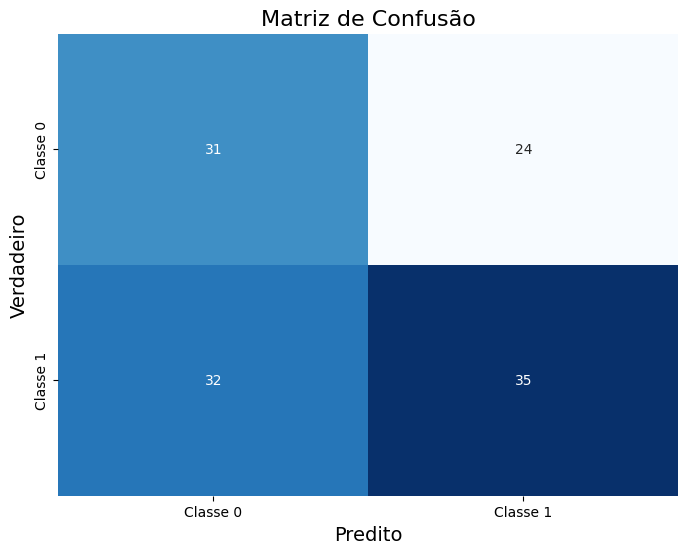

In [20]:
plot_confusion_matrix(y_petr4_test, y_pred)

### Diagnóstico

- Underfitting:  Não deve ter ocorrido muito. Obtivemos (f1-score=0.5376 | accuracy=0.5518), o que está relativamente próximo à resultados de trabalhos da litetura de predição do movimento de ações

- Overfitting: Não ocorreu. O modelo está com resultados até melhores no conjunto de teste em relação ao conjunto de treino.


O diagnóstico final é que o principal fenômeno ocorrido foi a sorte no conjunto de teste, e que o modelo está com um leve **underfitting**.

- Para evitar o problema do modelo ter sorte no conjunto de teste, poderíamos:
    - Aumentar o tamanho do conjunto de teste. Porém, não é algo que é possível fazer no momento.

- Para reduzir o underfitting, poderíamos:
    - Inserir mais features
    - *Mudança no espaço de busca de hiperparâmetros*: Modificar o espaço de busca para hiperparâmetros que tornem o modelo **mais complexo**

Como não houve muito underfitting e não podemos fazer muito quanto a aumentar o tamanho do conjunto de dados de teste, resolvemos concentrar esforços nos outros modelos.

## PETR4

Observando a quantidade de eventos no conjunto de treino/validação e teste. Podemos concluir que os modelos, por serem treinados com um dataset levemente desbalanceado, possuem maior viés para indicar a predição positiva `hasRise=1`, devido que, em geral, 

In [8]:
y_petr4_train.value_counts(normalize=True)

hasRise
1    0.541114
0    0.458886
Name: proportion, dtype: float64

In [9]:
y_petr4_test.value_counts(normalize=True)

hasRise
1    0.54918
0    0.45082
Name: proportion, dtype: float64

In [7]:
def objective_xgboost(trial):
    # Definir o espaço de busca dos hiperparâmetros
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'tree_method': 'auto',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'eta': trial.suggest_float('eta', 1e-4, 1e-1, log=True), # Learning rate
        'max_depth': trial.suggest_int('max_depth', 3, 10), # Profundida maxima das arvores
        'lambda': trial.suggest_float('lambda', 1e-4, 1.0, log=True), # Termo de regularização
    }
    
    # Configurando o KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    
    # Inicializando o modelo XGBoost
    model = XGBClassifier(**param)
    
    # Realizando a validação cruzada
    scores = cross_val_score(model, X_petr4_train, y_petr4_train, cv=kf, scoring='accuracy')
    
    # Retornando a média dos scores como objetivo a ser minimizado
    return np.mean(scores)

/home/julio/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
mlflow.set_experiment("XGBoost PETR4")
study = optuna.create_study(direction='maximize')
study.optimize(objective_xgboost, n_trials=500, callbacks=[mlflow_callback])


[I 2024-07-11 00:25:09,293] A new study created in memory with name: no-name-53e00cdd-f74f-4428-8e4f-93d829c14476
[I 2024-07-11 00:25:09,732] Trial 0 finished with value: 0.5040000000000001 and parameters: {'eta': 0.0007806914834225254, 'max_depth': 4, 'lambda': 0.0004524137343288781}. Best is trial 0 with value: 0.5040000000000001.
[I 2024-07-11 00:25:10,061] Trial 1 finished with value: 0.525438596491228 and parameters: {'eta': 0.00494726213806911, 'max_depth': 3, 'lambda': 0.0007495617170844204}. Best is trial 1 with value: 0.525438596491228.
[I 2024-07-11 00:25:10,436] Trial 2 finished with value: 0.5147017543859649 and parameters: {'eta': 0.029451184779344514, 'max_depth': 4, 'lambda': 0.08195447876112695}. Best is trial 1 with value: 0.525438596491228.
[I 2024-07-11 00:25:11,132] Trial 3 finished with value: 0.5387017543859649 and parameters: {'eta': 0.0025628899460961143, 'max_depth': 7, 'lambda': 0.0018754045833396088}. Best is trial 3 with value: 0.5387017543859649.
[I 2024-07

Best trial:
  Value: 0.6021052631578947
  Params: 
    eta: 0.07111263779692518
    max_depth: 7
    lambda: 0.048716073969606366


### Avaliação 

In [52]:
study.best_params


{'eta': 0.07111263779692518, 'max_depth': 7, 'lambda': 0.048716073969606366}

In [60]:
best_params = {'eta': 0.07111263779692518, 'max_depth': 7, 'lambda': 0.048716073969606366}
model = XGBClassifier(**best_params)

# Treinando o modelo no conjunto de treinamento completo
model = model.fit(X_petr4_train, y_petr4_train)

Exibindo os resultados do KFold no conjunto de treino para termos uma referência:

In [70]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
f1_kfold_scores = cross_val_score(model, X_petr4_train, y_petr4_train, cv=kf, scoring='f1').mean()
accuracy_kfold_scores = cross_val_score(model, X_petr4_train, y_petr4_train, cv=kf, scoring='accuracy').mean()

print(f'[TRAINING SET KFOLD] The model scored a mean of: f1-score={f1_kfold_scores:.4f} | accuracy={accuracy_kfold_scores:.4f}')

[TRAINING SET KFOLD] The model scored a mean of: f1-score=0.6369 | accuracy=0.6021


Resultados para o conjunto de teste:

In [67]:
# Avaliando o modelo
y_pred = model.predict(X_petr4_test)
report = classification_report(y_petr4_test, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.4369    0.8182    0.5696        55
           1     0.4737    0.1343    0.2093        67

    accuracy                         0.4426       122
   macro avg     0.4553    0.4763    0.3895       122
weighted avg     0.4571    0.4426    0.3717       122



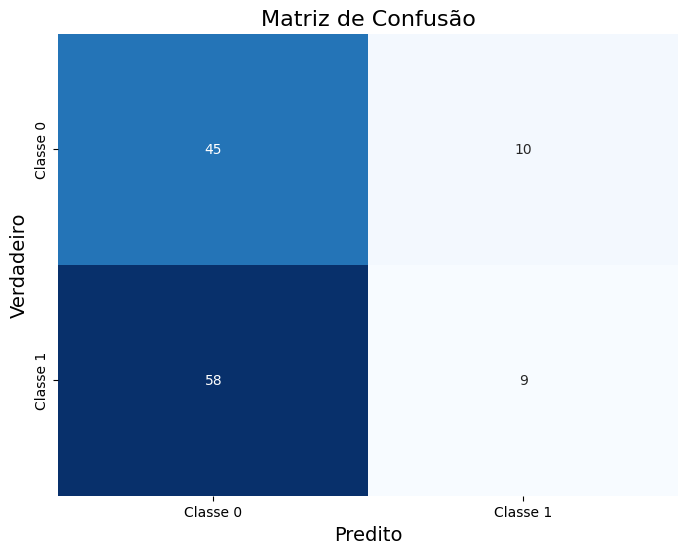

In [68]:
plot_confusion_matrix(y_petr4_test, y_pred)

### Diagnóstico

Podemos diagnosticar o modelo com **overfitting**, visto que os resultados no conjunto de treino (60,21% de acurácia, 0.6369 de F1-Score) estão significativamente superiores aos resultados do conjunto de teste (44,26% de acurácia, 0.2093 de F1-Score)

Após diagnosticar o problema de **overfitting**, podemos tentar melhorar o modelo tomando medidas como:
- *Reduzir features utilizadas*
- *Utilizar modelos mais simples*
- *Aumentar o tamanho do conjunto de treinamento*
- *Mudança no espaço de busca de hiperparâmetros*: Adicionar hiperparâmetros de regularização ou restringir o espaço de busca para hiperparâmetros que tornem o modelo menos complexo

#### Tentativa 1 de melhorar o modelo

##### - *Reduzir features utilizadas*: Removendo features com alta correlação

In [9]:
def get_highly_correlated_features(correlation_matrix, threshold):
  correlated_pairs = []
  for i in range(len(correlation_matrix.columns)):
    for j in range(i):
      if abs(correlation_matrix.iloc[i, j]) > threshold:
        pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
        coefficient = correlation_matrix.iloc[i, j]
        correlated_pairs.append((pair, coefficient))
  return sorted(correlated_pairs, key= lambda pair: pair[1], reverse=True)

MAX_CORRELATION = 0.90

corr_matrix = X_petr4_train.corr(method='spearman').abs()
correlation_list = get_highly_correlated_features(corr_matrix, MAX_CORRELATION)
len(correlation_list), correlation_list[:10]


(53,
 [(('bom negócio_count', 'valorização_count'), 1.0),
  (('lucro_count', 'valorização_count'), 1.0),
  (('lucro_count', 'bom negócio_count'), 1.0),
  (('neutro_count', 'valorização_count'), 1.0),
  (('neutro_count', 'bom negócio_count'), 1.0),
  (('neutro_count', 'lucro_count'), 1.0),
  (('desvalorização_count', 'valorização_count'), 1.0),
  (('desvalorização_count', 'bom negócio_count'), 1.0),
  (('desvalorização_count', 'lucro_count'), 1.0),
  (('desvalorização_count', 'neutro_count'), 1.0)])

Temos 53 PARES features com correlação maior que 0.95! Vamos remover um dos elementos dos pares para reduzir essa redundância

In [10]:
# Drop high correlated features in correlation list

f2drop = []
for feature_pair, _ in correlation_list:
  if feature_pair[0] not in f2drop and feature_pair[1] not in f2drop:
    f2drop.append(feature_pair[1])

X_petr4_train_reduced = X_petr4_train.drop(f2drop, axis='columns')
X_petr4_test_reduced = X_petr4_test.drop(f2drop, axis='columns')

In [11]:
X_petr4_train.shape, X_petr4_train_reduced.shape 

((377, 62), (377, 38))

##### - *Mudança no espaço de busca de hiperparâmetros*: Adicionar hiperparâmetros de regularização ou restringir o espaço de busca para hiperparâmetros que tornem o modelo menos complexo

In [54]:
def objective_xgboost(trial):
    # Definir o espaço de busca dos hiperparâmetros
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'tree_method': 'auto',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'eta': trial.suggest_float('eta', 1e-4, 1e-1, log=True), # Learning rate
        'max_depth': trial.suggest_int('max_depth', 2, 5), # Profundida maxima das arvores
        'lambda': trial.suggest_float('lambda', 5e-2, 5.0, log=True), # Termo de regularização
    }
    
    # Configurando o KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    
    # Inicializando o modelo XGBoost
    model = XGBClassifier(**param)
    
    # Realizando a validação cruzada
    scores = cross_val_score(model, X_petr4_train_reduced, y_petr4_train, cv=kf, scoring='accuracy')
    
    # Retornando a média dos scores como objetivo a ser minimizado
    return np.mean(scores)

In [55]:
mlflow.set_experiment("XGBoost PETR4 Trial 2")
study = optuna.create_study(direction='maximize')
study.optimize(objective_xgboost, n_trials=300, callbacks=[mlflow_callback])


2024/07/11 04:09:15 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost PETR4 Trial 2' does not exist. Creating a new experiment.
[I 2024-07-11 04:09:15,978] A new study created in memory with name: no-name-42be05fc-ea70-46f1-94bb-65f2a8a9d07d
[I 2024-07-11 04:09:16,383] Trial 0 finished with value: 0.5118947368421053 and parameters: {'eta': 0.0007130657326031604, 'max_depth': 5, 'lambda': 0.6254348706360587}. Best is trial 0 with value: 0.5118947368421053.
[I 2024-07-11 04:09:16,717] Trial 1 finished with value: 0.536 and parameters: {'eta': 0.01547788687033158, 'max_depth': 5, 'lambda': 0.057990840139603345}. Best is trial 1 with value: 0.536.
[I 2024-07-11 04:09:16,942] Trial 2 finished with value: 0.5385964912280702 and parameters: {'eta': 0.030215267201173093, 'max_depth': 3, 'lambda': 4.131315117247216}. Best is trial 2 with value: 0.5385964912280702.
[I 2024-07-11 04:09:17,275] Trial 3 finished with value: 0.5197894736842106 and parameters: {'eta': 0.00038440018492649054,

##### Avaliação 

In [56]:
study.best_params


{'eta': 0.019028892621096086, 'max_depth': 2, 'lambda': 0.3047770889382631}

In [57]:
best_params = {'eta': 0.019028892621096086, 'max_depth': 2, 'lambda': 0.3047770889382631}
model = XGBClassifier(**best_params)

# Treinando o modelo no conjunto de treinamento completo
model = model.fit(X_petr4_train_reduced, y_petr4_train)

Exibindo os resultados do KFold no conjunto de treino para termos uma referência:

In [58]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
f1_kfold_scores = cross_val_score(model, X_petr4_train_reduced, y_petr4_train, cv=kf, scoring='f1').mean()
accuracy_kfold_scores = cross_val_score(model, X_petr4_train_reduced, y_petr4_train, cv=kf, scoring='accuracy').mean()

print(f'[TRAINING SET KFOLD] The model scored a mean of: f1-score={f1_kfold_scores:.4f} | accuracy={accuracy_kfold_scores:.4f}')

[TRAINING SET KFOLD] The model scored a mean of: f1-score=0.6422 | accuracy=0.5678


Resultados para o conjunto de teste:

In [59]:
# Avaliando o modelo
y_pred = model.predict(X_petr4_test_reduced)
report = classification_report(y_petr4_test, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.4340    0.4182    0.4259        55
           1     0.5362    0.5522    0.5441        67

    accuracy                         0.4918       122
   macro avg     0.4851    0.4852    0.4850       122
weighted avg     0.4901    0.4918    0.4908       122



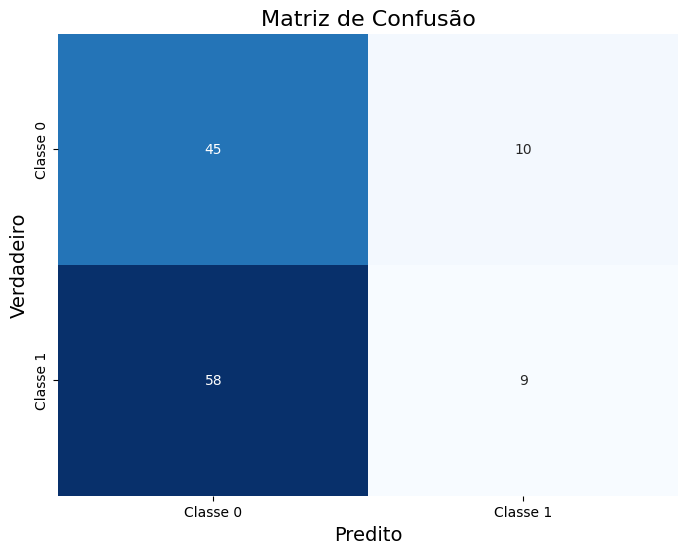

In [ ]:
plot_confusion_matrix(y_petr4_test, y_pred)

Os resultados melhoraram! Mas ainda assim, a acurácia permanece menor do que 50%. Vamos fazer um experimento: incluir mais dados no conjunto de treino para verificar como o resultado se comporta. Visto que ainda estamos tratando de um problema de overfitting, é esperado que os resultados melhorem

#### Tentativa 2 de melhorar o modelo

Vamos fazer um experimento: incluir mais dados no conjunto de treino para verificar como o resultado se comporta. Visto que ainda estamos tratando de um problema de overfitting, é esperado que os resultados melhorem

In [ ]:
df_petr4_test = df_petr4_test.set_index('Date')

In [27]:
CUTOFF_DATE = '2024-03-01'

df_petr4_test_until_2023_03_01 = df_petr4_test[:CUTOFF_DATE].reset_index()
df_petr4_test_from_2023_03_01 = df_petr4_test[CUTOFF_DATE:].reset_index()


In [28]:
df_petr4_train_until_2023_03_01 = pd.concat([df_petr4_train, df_petr4_test_until_2023_03_01], ignore_index=True)

In [29]:
X_petr4_train_until_2023_03_01 = df_petr4_train_until_2023_03_01.drop(['hasRise', 'Date'], axis='columns')
y_petr4_train_until_2023_03_01 = df_petr4_train_until_2023_03_01['hasRise']

X_petr4_test_from_2023_03_01 = df_petr4_test_from_2023_03_01.drop(['hasRise', 'Date'], axis='columns')
y_petr4_test_from_2023_03_01 = df_petr4_test_from_2023_03_01['hasRise']

In [30]:
(X_petr4_train_until_2023_03_01.shape, y_petr4_train_until_2023_03_01.shape), \
(X_petr4_test_from_2023_03_01.shape, y_petr4_test_from_2023_03_01.shape)

(((438, 62), (438,)), ((62, 62), (62,)))

Utilizando técnicas da Tentativa 1:

In [31]:
# Dropping highly correlated columns
X_petr4_train_until_2023_03_01_reduced = X_petr4_train_until_2023_03_01.drop(f2drop, axis='columns')
X_petr4_test_from_2023_03_01_reduced = X_petr4_test_from_2023_03_01.drop(f2drop, axis='columns')

In [32]:
# Usando espaço de busca de parâmetros focado em modelos mais simples, que tende a reduzir overfitting

def objective_xgboost(trial):
    # Definir o espaço de busca dos hiperparâmetros
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'tree_method': 'auto',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'eta': trial.suggest_float('eta', 1e-4, 1e-1, log=True), # Learning rate
        'max_depth': trial.suggest_int('max_depth', 2, 5), # Profundida maxima das arvores
        'lambda': trial.suggest_float('lambda', 5e-2, 5.0, log=True), # Termo de regularização
    }
    
    # Configurando o KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    
    # Inicializando o modelo XGBoost
    model = XGBClassifier(**param)
    
    # Realizando a validação cruzada
    scores = cross_val_score(model, X_petr4_train_until_2023_03_01_reduced, y_petr4_train_until_2023_03_01, cv=kf, scoring='accuracy')
    
    # Retornando a média dos scores como objetivo a ser minimizado
    return np.mean(scores)

In [33]:
mlflow.set_experiment("XGBoost PETR4 Trial 3")
study = optuna.create_study(direction='maximize')
study.optimize(objective_xgboost, n_trials=300, callbacks=[mlflow_callback])

2024/07/11 17:35:33 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost PETR4 Trial 3' does not exist. Creating a new experiment.
[I 2024-07-11 17:35:33,473] A new study created in memory with name: no-name-c44b72f5-5074-4daa-a497-0e02aefe6a0c
[I 2024-07-11 17:35:33,850] Trial 0 finished with value: 0.5547283176593523 and parameters: {'eta': 0.0021230155349115046, 'max_depth': 4, 'lambda': 0.7273392017486725}. Best is trial 0 with value: 0.5547283176593523.
[I 2024-07-11 17:35:34,146] Trial 1 finished with value: 0.5595350052246604 and parameters: {'eta': 0.03589872495085163, 'max_depth': 3, 'lambda': 4.518989328421604}. Best is trial 1 with value: 0.5595350052246604.
[I 2024-07-11 17:35:34,336] Trial 2 finished with value: 0.5275339602925809 and parameters: {'eta': 0.04365461049388009, 'max_depth': 2, 'lambda': 0.42211283412535305}. Best is trial 1 with value: 0.5595350052246604.
[I 2024-07-11 17:35:34,719] Trial 3 finished with value: 0.5409352142110763 and parameters: {'eta':

##### Avaliação 

In [34]:
study.best_params


{'eta': 0.010685693006271493, 'max_depth': 5, 'lambda': 2.7037154767052773}

In [35]:
best_params = {'eta': 0.010685693006271493, 'max_depth': 5, 'lambda': 2.7037154767052773}
model = XGBClassifier(**best_params)

# Treinando o modelo no conjunto de treinamento completo
model = model.fit(X_petr4_train_until_2023_03_01_reduced, y_petr4_train_until_2023_03_01)

Exibindo os resultados do KFold no conjunto de treino para termos uma referência:

In [36]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
f1_kfold_scores = cross_val_score(model, X_petr4_train_until_2023_03_01_reduced, y_petr4_train_until_2023_03_01, cv=kf, scoring='f1').mean()
accuracy_kfold_scores = cross_val_score(model, X_petr4_train_until_2023_03_01_reduced, y_petr4_train_until_2023_03_01, cv=kf, scoring='accuracy').mean()

print(f'[TRAINING SET KFOLD] The model scored a mean of: f1-score={f1_kfold_scores:.4f} | accuracy={accuracy_kfold_scores:.4f}')

[TRAINING SET KFOLD] The model scored a mean of: f1-score=0.6522 | accuracy=0.5868


Resultados para o conjunto de teste:

In [37]:
# Avaliando o modelo
y_pred = model.predict(X_petr4_test_from_2023_03_01_reduced)
report = classification_report(y_petr4_test_from_2023_03_01, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.5263    0.3571    0.4255        28
           1     0.5814    0.7353    0.6494        34

    accuracy                         0.5645        62
   macro avg     0.5539    0.5462    0.5374        62
weighted avg     0.5565    0.5645    0.5483        62



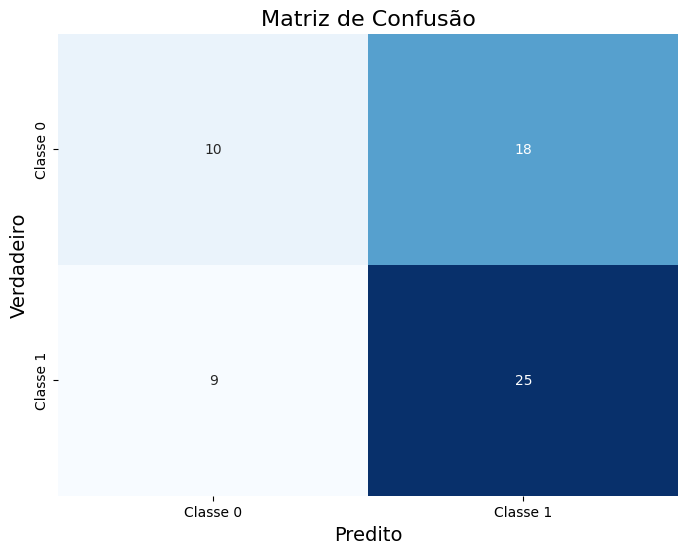

In [39]:
plot_confusion_matrix(y_petr4_test_from_2023_03_01, y_pred)

Reduzimos overfitting com sucesso! Agora temos os seguinte resultados:
- Treino: f1-score=0.6522 | accuracy=0.5868
- Teste: f1-score=0.6494 | accuracy=0.5645

Que nos permitem concluir que overfitting não está acontecendo, visto que os resultados do treino/validação e teste estão próximos.


Porém, uma observação relevante é que o modelo está enviesado para prever que a ação vai subir. Podemos notar isso observando as 43 predições da classe `1` contra 19 predições da classe `0`. 